# Getting Started

We start by importing the library and configuring matplotlib to display the figures in a nice way.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys; sys.path.append('..')
import pyzx as zx

%config InlineBackend.figure_format = 'svg'

Then we can create a new random Clifford circuit and visualise it.

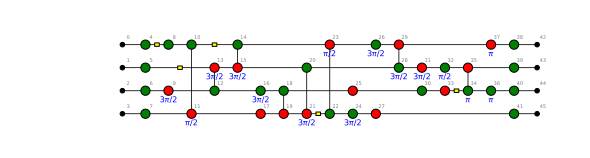

In [2]:
qubit_amount = 4
depth = 15
circ = zx.cliffords(qubit_amount, depth)
zx.draw(circ,labels=True,h_edge_draw='box')

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

Internally this circuit is represented as a graph:

In [3]:
print(circ)
print("All edges: ", list(circ.edges()))
print("\nThe neighbours of a paricular vertex: ", list(circ.neighbours(14)))

Graph(46 vertices, 50 edges)
All edges:  [(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 13), (6, 9), (7, 11), (8, 10), (9, 12), (10, 11), (10, 14), (11, 17), (12, 16), (12, 13), (13, 15), (14, 23), (14, 15), (15, 20), (16, 18), (17, 19), (18, 25), (18, 19), (19, 21), (20, 28), (20, 21), (21, 22), (22, 24), (22, 23), (23, 26), (24, 27), (25, 30), (26, 29), (27, 41), (28, 29), (28, 31), (29, 37), (30, 33), (31, 32), (32, 35), (33, 34), (34, 35), (34, 36), (35, 39), (36, 40), (37, 38), (38, 42), (39, 43), (40, 44), (41, 45)]

The neighbours of a paricular vertex:  [10, 23, 15]


Using this graph representation we can use the rules of the ZX-calculus to simplify it:

In [12]:
g = circ.copy()
zx.clifford_simp(g)

spider_simp
5. 3. 3. 1. 
finished in 5 iterations
spider_simp
3. 
finished in 2 iterations
pivot_simp
4. 2. 
finished in 3 iterations
lcomp_simp
4. 1. 1. 
finished in 4 iterations
pivot_simp
1. 1. 
finished in 3 iterations
id_simp
1. 
finished in 2 iterations
spider_simp

finished in 1 iterations


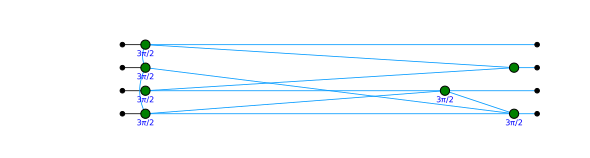

In [13]:
zx.draw(g)

The blue lines represent edges that have a Hadamard gate on them. This reduces the clutter of the following:

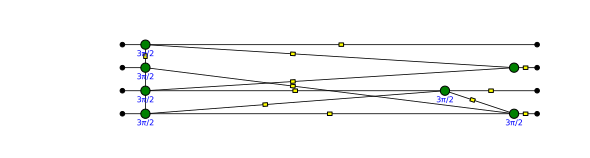

In [6]:
zx.draw(g, h_edge_draw='box')

We can also reformat the graph to look a bit nicer:

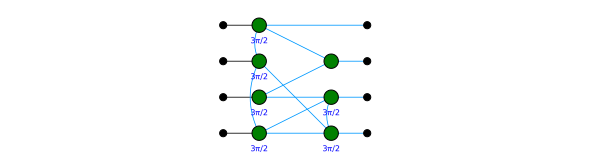

In [15]:
zx.drawing.pack_circuit_nf(g,'grg')  # Reposition nodes horizontally to look nicer
zx.draw(g)

Let's try to see in a bit more detail what goes into rewriting this circuit.

In [3]:
from ipywidgets import widgets
from IPython.display import display, Markdown

from pyzx.simplify import clifford_iter

graph = circ.copy()
graphs = [zx.draw(graph)]
names = ["start"]
for g, n in clifford_iter(graph):
    graphs.append(zx.draw(g))
    names.append(n)

def plotter(step):
    display(Markdown("Rewrite step: " + names[step]))
    display(graphs[step])

w = widgets.interactive(plotter, step=(0,len(graphs)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,50*len(graphs)))
output = w.children[-1]
output.layout.height = "{!s}px".format(200+qubit_amount*20)
w

interactive(children=(IntSlider(value=7, description='step', layout=Layout(width='800px'), max=15), Output(lay…

As you can see, the first few steps are **spider fusion**, where adjacent red nodes and adjacent green nodes are fused together (and their phases added). The next step is to convert all red nodes to green nodes by changing regular edges to hadamard edges.

Now come the two steps that do most of the work. The first is that of doing specific **local complementations**. This looks for green nodes with a phase of $\frac\pi2$ or $\frac{3\pi}2$ and does a local complementation resulting in the deletion of a node. This is done until no more nodes with such a phase can be found. Next we do a round of **pivots**. This looks for pairs of nodes that have a zero or $\pi$ phase. It does a transformation to the graph that allows both these nodes to be deleted. 

Finally, we greedily try to reduce the amount of Hadamard edges by converting green nodes back into red nodes again and we remove phase gates that have a phase of zero as these are just the identity.

**Note**: Depending on the circuit that was generated, any of these steps might not have been done.